### In this notebook we will run 2 Models using a sarcasm dataset: 
### 1 with a Bidirectional LSTM as its layer and another with 1D Convolutional layer. 
### We will then plot the accuracy and loss of the two models and compare it

In [3]:
# Import required libraries
import numpy as np
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Import dataset

In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
#     -O D:/Tanuj/Projects/Deep_Learning_TensorFlow/Natural-Language-Processing-in-TensorFlow/Conv_vs_GRU_dataset/sarcasm.json

In [4]:
vocab_size = 1000          # Define the vocabulary size to be used by the tokenizer.
embedding_dim = 16         # Dimension of the dense embedding. Each word will be represented as a 16-dimensional vector.
max_length = 120           # Maximum length of all sequences. Sequences longer than this will be truncated, and shorter ones will be padded.
trunc_type = 'post'        # Truncate sequences from the end (post) if they exceed the maximum length.
padding_type = 'post'      # Pad sequences at the end (post) to ensure all sequences are of the same length.
oov_tok = "<OOV>"          # Token used to represent words that are out-of-vocabulary (i.e., not present in the training set).
training_size = 20000      # Number of samples to be used for training.

# Open the JSON file containing the dataset.
with open("Conv_vs_GRU_dataset/sarcasm.json", 'r') as f:
    datastore = json.load(f)  # Load the data from the JSON file into the datastore variable.

sentences = []  # Initialize an empty list to store the sentences.
labels = []     # Initialize an empty list to store the labels.
urls = []       # Initialize an empty list to store the URLs (not used further in the code).

# Loop through each item in the datastore.
for item in datastore:
    sentences.append(item['headline'])   # Append the headline to the sentences list.
    labels.append(item['is_sarcastic'])  # Append the label (0 or 1) to the labels list.

# Split the data into training and testing sets.
training_sentences = sentences[0:training_size]  # Get the first `training_size` sentences for training.
testing_sentences = sentences[training_size:]    # Get the remaining sentences for testing.
training_labels = labels[0:training_size]        # Get the first `training_size` labels for training.
testing_labels = labels[training_size:]          # Get the remaining labels for testing.

# Initialize the tokenizer with a vocabulary size limit and an OOV token.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)  # Fit the tokenizer on the training sentences.

word_index = tokenizer.word_index  # Get the word index dictionary that maps words to their index.

# Convert the training sentences to sequences of integers.
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# Pad the training sequences to ensure they all have the same length.
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the testing sentences to sequences of integers.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# Pad the testing sequences to ensure they all have the same length.
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Model with Bidirectional LSTM as a Layer

In [5]:
# Initialize a Sequential model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model with binary crossentropy loss, the Adam optimizer, and accuracy as a metric.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50 

# Convert the padded sequences and labels to numpy arrays.
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Train the model using the training data and validate using the testing data.
history_LSTM = model.fit(training_padded, training_labels, epochs=num_epochs, 
                         validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 42s 40ms/step - loss: 0.4909 - accuracy: 0.7640 - val_loss: 0.39

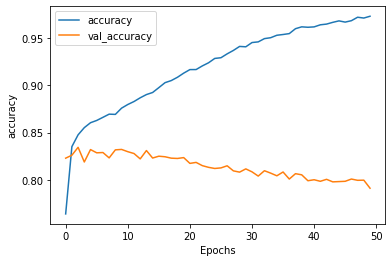

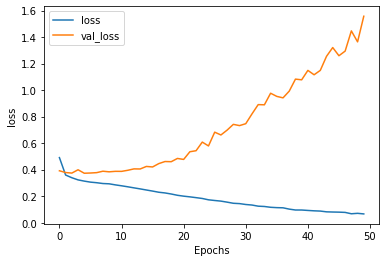

In [7]:
# Plot accuracy and loss for training and validation
def plot_graphs(history_LSTM, string):
  plt.plot(history_LSTM.history[string])
  plt.plot(history_LSTM.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

Model with 1D Convolutional as a Layer

In [8]:
# Initialize a Sequential model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model with binary crossentropy loss, the Adam optimizer, and accuracy as a metric.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

# Convert the padded sequences and labels to numpy arrays.
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Train the model using the training data and validate using the testing data.
history_conv = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
__________________________________________________

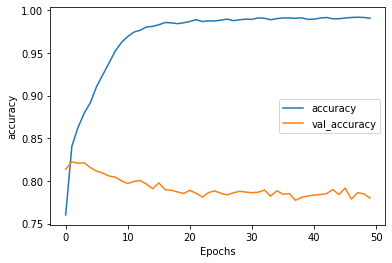

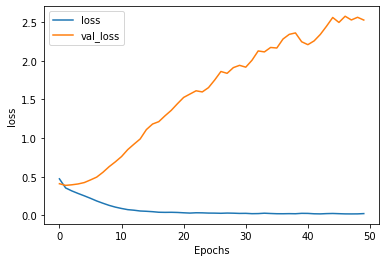

In [9]:
# Plot accuracy and loss for training and validation
def plot_graphs(history_conv, string):
  plt.plot(history_conv.history[string])
  plt.plot(history_conv.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')